# Cytokine Signaling Dynamics — 10-Cytokine Subset Experiment

Runs the full AB-MIL pipeline on a curated 10-cytokine subset + PBS control.

## Rationale for cytokine selection

The subset is designed to provide a **clear expected contrast** between easy-to-learn
(high learnability AUC) and hard-to-learn (low AUC) cytokines, grounded in both
the literature and preliminary full-experiment rankings reported in the source paper.

The hard group includes IL-12 as a **cascade positive control**: the paper (Fig. 4i)
explicitly shows that IL-12 drives its PBMC effects indirectly via IFN-γ induction,
making it a clean test of whether the model recovers secondary-cascade cytokines as
harder to learn than direct activators.

### Expected easy group — direct, PBMC-specific, strong 24-h transcriptional response
| Cytokine | Key mechanism | Evidence |
|---|---|---|
| IL-4 | Strong Th2/B cell axis via STAT6 | Ranked #1 in full-experiment preliminary run |
| M-CSF | Direct monocyte survival/activation via CSF1R | Ranked #3 in preliminary run |
| IL-10 | Strong monocyte/B cell response via STAT3 | Ranked #4 in preliminary run |
| TNF-alpha | Canonical early NF-κB in monocytes/T cells | Well-established rapid inflammatory activator |
| IL-2 | Direct T/NK activation via γc receptor | Ranked #10 in preliminary run |

### Expected hard group — indirect, non-PBMC targets, or cascade-dependent
| Cytokine | Key mechanism | Why hard |
|---|---|---|
| IL-22 | Epithelial STAT3 via IL-22R1 | Targets epithelium, not PBMCs — minimal direct PBMC signal |
| VEGF | Endothelial growth via VEGFR | Endothelial target; PBMCs lack significant VEGFR expression |
| IL-12 | IFN-γ induction in NK/T cells | **Cascade control**: effect is indirect (Fig. 4i explicitly shows secondary IFN-γ cascade) |
| OSM | Oncostatin M via gp130 | Non-PBMC primary targets; ranked near bottom in preliminary run |
| HGF | Hepatocyte growth via c-Met | Hepatocyte/stromal target; minimal direct PBMC transcriptional response |

**Pre-registered predictions:**
- IL-4, M-CSF, IL-10 should rank in the top 3 by learnability AUC.
- IL-22, VEGF, HGF should rank in the bottom 3.
- IL-12 should rank low despite being immunostimulatory (indirect cascade effect, not direct PBMC activation).

Connect to the cluster kernel before running.
All paths in `configs/default.yaml` point to cluster storage.

In [1]:
import json
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import spearmanr
from torch.utils.data import DataLoader

from cytokine_mil.data.label_encoder import CytokineLabel
from cytokine_mil.data.dataset import PseudoTubeDataset, CellDataset
from cytokine_mil.models.instance_encoder import InstanceEncoder
from cytokine_mil.models.attention import AttentionModule
from cytokine_mil.models.bag_classifier import BagClassifier
from cytokine_mil.models.cytokine_abmil import CytokineABMIL
from cytokine_mil.training.train_encoder import train_encoder
from cytokine_mil.training.train_mil import train_mil
from cytokine_mil.experiment_setup import (
    build_stage1_manifest,
    filter_manifest,
    split_manifest_by_donor,
    build_encoder,
    build_mil_model,
)
from cytokine_mil.analysis.dynamics import (
    aggregate_to_donor_level,
    rank_cytokines_by_learnability,
    compute_cytokine_entropy_summary,
    compute_confusion_entropy_summary,
    build_cell_type_confidence_matrix,
)
from cytokine_mil.analysis.validation import (
    check_seed_stability,
    check_functional_groupings,
)

In [2]:
# --- Config ---
with open("cytokines/cytokines-mil/configs/default.yaml") as f:
    cfg = yaml.safe_load(f)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = cfg["dynamics"]["random_seeds"][0]
print(f"Device: {DEVICE}")
print(f"Seed: {SEED}")

Device: cuda
Seed: 42


## 1. Data

In [3]:
MANIFEST_PATH = cfg["data"]["manifest_path"]

with open(MANIFEST_PATH) as f:
    manifest = json.load(f)

# Load HVG list (saved by preprocess_tubes.ipynb)
HVG_PATH = str(Path(MANIFEST_PATH).parent / "hvg_list.json")
with open(HVG_PATH) as f:
    gene_names = json.load(f)

print(f"Full manifest entries: {len(manifest)}")
print(f"HVGs: {len(gene_names)}")

Full manifest entries: 10920
HVGs: 4000


In [4]:
# --- Cytokine subset selection ---
# Verify that these names exactly match the cytokine field in your manifest.json.
# Run the cell below to cross-check before proceeding.
# NOTE: TNF-alpha naming may vary (e.g. "TNF-alpha", "TNFa", "TNF") — adjust if flagged.

# 5 cytokines with direct, PBMC-specific, strong effects — expected easy to learn
EASY_CYTOKINES = [
    "IL-4",        # #1 in preliminary run — strong Th2/B cell axis via STAT6
    "M-CSF",       # #3 in preliminary run — direct monocyte survival/activation via CSF1R
    "IL-10",       # #4 in preliminary run — strong monocyte/B cell STAT3 response
    "TNF-alpha",   # canonical NF-κB activator — rapid direct effect on monocytes/T cells
    "IL-2",        # #10 in preliminary run — direct T/NK activation via γc receptor
]

# 5 cytokines with indirect, non-PBMC-primary, or cascade-dependent effects — expected hard to learn
HARD_CYTOKINES = [
    "IL-22",   # targets epithelium via IL-22R1 — minimal direct PBMC transcriptional signal
    "VEGF",    # endothelial target via VEGFR — PBMCs lack significant VEGFR expression
    "IL-12",   # cascade control: drives IFN-γ in NK/T cells indirectly (Fig. 4i in source paper)
    "OSM",     # Oncostatin M — non-PBMC primary targets, near bottom in preliminary run
    "HGF",     # hepatocyte/stromal target via c-Met — weak direct PBMC response
]

SUBSET_CYTOKINES = EASY_CYTOKINES + HARD_CYTOKINES

# Verify names against manifest before continuing
manifest_cytokines = {e["cytokine"] for e in manifest}
missing = [c for c in SUBSET_CYTOKINES if c not in manifest_cytokines]
if missing:
    print(f"WARNING — cytokines not found in manifest (check naming): {missing}")
    print(f"Available names (sample): {sorted(manifest_cytokines)[:20]}")
else:
    print("All selected cytokines found in manifest.")
print(f"Selected {len(SUBSET_CYTOKINES)} cytokines: {SUBSET_CYTOKINES}")

All selected cytokines found in manifest.
Selected 10 cytokines: ['IL-4', 'M-CSF', 'IL-10', 'TNF-alpha', 'IL-2', 'IL-22', 'VEGF', 'IL-12', 'OSM', 'HGF']


In [5]:
# Filter manifest to the 10-cytokine subset + PBS
subset_manifest = filter_manifest(manifest, cytokines=SUBSET_CYTOKINES, include_pbs=True)

# Count classes: 10 cytokines + PBS = 11
subset_cytokine_names = {e["cytokine"] for e in subset_manifest}
print(f"Subset manifest entries: {len(subset_manifest)}")
print(f"Unique classes: {sorted(subset_cytokine_names)}")
print(f"n_classes = {len(subset_cytokine_names)}  (10 cytokines + PBS)")

Subset manifest entries: 1320
Unique classes: ['HGF', 'IL-10', 'IL-12', 'IL-2', 'IL-22', 'IL-4', 'M-CSF', 'OSM', 'PBS', 'TNF-alpha', 'VEGF']
n_classes = 11  (10 cytokines + PBS)


In [6]:
# Label encoder — fitted on subset manifest for consistent index mapping
LABEL_ENCODER_PATH = str(Path(MANIFEST_PATH).parent / "label_encoder_subset.json")
label_encoder = CytokineLabel().fit(subset_manifest)
label_encoder.save(LABEL_ENCODER_PATH)
print(f"Classes: {label_encoder.n_classes()} (PBS at index {label_encoder.encode('PBS')})")

Classes: 91 (PBS at index 90)


In [7]:
# --- Donor-level train/val split (see CLAUDE.md Section 16) ---
# D2 and D3 are the most biologically distinct donors in the cohort.
# They are held out for generalization testing and never used in optimizer steps.
# VAL_DONORS = cfg["data"]["val_donors"]  # ["Donor2", "Donor3"]
VAL_DONORS = ["Donor2", "Donor3"]
train_manifest, val_manifest = split_manifest_by_donor(subset_manifest, val_donors=VAL_DONORS)
print(f"Train donors: {sorted({e['donor'] for e in train_manifest})}  ({len(train_manifest)} tubes)")
print(f"Val donors:   {sorted({e['donor'] for e in val_manifest})}  ({len(val_manifest)} tubes)")

# Save manifests for dataset construction
SUBSET_MANIFEST_PATH = str(Path(MANIFEST_PATH).parent / "manifest_subset.json")
TRAIN_MANIFEST_PATH  = str(Path(MANIFEST_PATH).parent / "manifest_subset_train.json")
VAL_MANIFEST_PATH    = str(Path(MANIFEST_PATH).parent / "manifest_subset_val.json")
with open(SUBSET_MANIFEST_PATH, "w") as f:
    json.dump(subset_manifest, f)
with open(TRAIN_MANIFEST_PATH, "w") as f:
    json.dump(train_manifest, f)
with open(VAL_MANIFEST_PATH, "w") as f:
    json.dump(val_manifest, f)

# Pseudo-tube datasets (Stage 2/3) — train and val separate
# preload=True: loads all tubes as sparse matrices at init — eliminates disk I/O during training.
train_tube_dataset = PseudoTubeDataset(TRAIN_MANIFEST_PATH, label_encoder, gene_names=gene_names, preload=True)
val_tube_dataset   = PseudoTubeDataset(VAL_MANIFEST_PATH,   label_encoder, gene_names=gene_names, preload=True)
print(f"Train tubes: {len(train_tube_dataset)}")
print(f"Val tubes:   {len(val_tube_dataset)}")

# --- Stage 1 manifest: one tube per cytokine, rotating donors (train donors only) ---
STAGE1_MANIFEST_PATH = str(Path(MANIFEST_PATH).parent / "manifest_stage1_subset.json")
_stage1_manifest = build_stage1_manifest(train_manifest, save_path=STAGE1_MANIFEST_PATH)

# preload=True: loads all cells at init → in-memory shuffling, no disk I/O per batch
cell_dataset = CellDataset(STAGE1_MANIFEST_PATH, gene_names=gene_names, preload=True)
print(f"Cells: {len(cell_dataset)}")
print(f"Cell types: {cell_dataset.n_cell_types()}")
print(f"NaN in X: {np.isnan(cell_dataset._X).any()}")
print(f"Inf in X: {np.isinf(cell_dataset._X).any()}")
print(f"X range: [{cell_dataset._X.min():.3f}, {cell_dataset._X.max():.3f}]")

cell_loader = DataLoader(cell_dataset, batch_size=256, shuffle=True, num_workers=0)

Train donors: ['Donor1', 'Donor10', 'Donor11', 'Donor12', 'Donor4', 'Donor5', 'Donor6', 'Donor7', 'Donor8', 'Donor9']  (1100 tubes)
Val donors:   ['Donor2', 'Donor3']  (220 tubes)


Preloading tubes: 100%|██████████████████████| 220/220 [00:25<00:00,  8.55it/s]


Train tubes: 1100
Val tubes:   220
Cells: 4873
Cell types: 18
NaN in X: False
Inf in X: False
X range: [0.000, 7.752]


## 2. Stage 1 — Encoder Pre-training

In [8]:
encoder = build_encoder(
    n_input_genes=len(gene_names),
    n_cell_types=cell_dataset.n_cell_types(),
    embed_dim=cfg["model"]["embedding_dim"],
)

encoder = train_encoder(
    encoder,
    cell_loader,
#    n_epochs=cfg["training"]["stage1_epochs"],
    n_epochs=10,
    lr=cfg["training"]["lr"],
    momentum=cfg["training"]["momentum"],
    device=DEVICE,
    verbose=True,
)

torch.save(encoder.state_dict(), "encoder_stage1_subset.pt")
print("Encoder saved.")

[Stage 1] Epoch   1/10 | loss=2.1681 | acc=0.3883


[Stage 1] Epoch   2/10 | loss=0.5019 | acc=0.8180


[Stage 1] Epoch   3/10 | loss=0.3177 | acc=0.8857


[Stage 1] Epoch   4/10 | loss=0.2160 | acc=0.9261


[Stage 1] Epoch   5/10 | loss=0.1542 | acc=0.9532


[Stage 1] Epoch   6/10 | loss=0.1206 | acc=0.9600


[Stage 1] Epoch   7/10 | loss=0.0729 | acc=0.9832


[Stage 1] Epoch   8/10 | loss=0.0428 | acc=0.9947


[Stage 1] Epoch   9/10 | loss=0.0208 | acc=0.9992


[Stage 1] Epoch  10/10 | loss=0.0136 | acc=0.9998
Encoder saved.


## 3. Stage 2 — MIL Training (encoder frozen)

In [10]:
cfg["training"]["lr"] = 0.001

In [11]:
# n_classes derived from the label encoder — 11 for the 10-cytokine subset + PBS
mil_model = build_mil_model(
    encoder,
    embed_dim=cfg["model"]["embedding_dim"],
    attention_hidden_dim=cfg["model"]["attention_hidden_dim"],
    n_classes=label_encoder.n_classes(),
    encoder_frozen=True,
)

dynamics_stage2 = train_mil(
    mil_model,
    train_tube_dataset,                              # train donors only
    n_epochs=50,
    #n_epochs=cfg["training"]["stage2_epochs"],
    lr=cfg["training"]["lr"],
    momentum=cfg["training"]["momentum"],
    lr_scheduler=cfg["training"]["lr_scheduler"],
    lr_warmup_epochs=cfg["training"]["lr_warmup_epochs"],
    log_every_n_epochs=cfg["dynamics"]["log_every_n_epochs"],
    device=DEVICE,
    seed=SEED,
    verbose=True,
    val_dataset=val_tube_dataset,                    # observer only — no gradient updates
)

torch.save(mil_model.state_dict(), "mil_stage2_subset.pt")
print("Stage 2 model saved.")
print(f"Train records: {len(dynamics_stage2['records'])}")
print(f"Val records:   {len(dynamics_stage2['val_records'])}")

[Stage 2/3] Epoch   1/50 | loss=2.9648


[Stage 2/3] Epoch   2/50 | loss=2.2708


[Stage 2/3] Epoch   3/50 | loss=2.1971


[Stage 2/3] Epoch   4/50 | loss=2.0919


[Stage 2/3] Epoch   5/50 | loss=1.9701


[Stage 2/3] Epoch   6/50 | loss=1.8446


[Stage 2/3] Epoch   7/50 | loss=1.7333


[Stage 2/3] Epoch   8/50 | loss=1.6430


[Stage 2/3] Epoch   9/50 | loss=1.5671


[Stage 2/3] Epoch  10/50 | loss=1.5021


[Stage 2/3] Epoch  11/50 | loss=1.4434


[Stage 2/3] Epoch  12/50 | loss=1.3921


[Stage 2/3] Epoch  13/50 | loss=1.3427


[Stage 2/3] Epoch  14/50 | loss=1.2983


[Stage 2/3] Epoch  15/50 | loss=1.2582


[Stage 2/3] Epoch  16/50 | loss=1.2191


[Stage 2/3] Epoch  17/50 | loss=1.1801


[Stage 2/3] Epoch  18/50 | loss=1.1420


[Stage 2/3] Epoch  19/50 | loss=1.1039


[Stage 2/3] Epoch  20/50 | loss=1.0671


[Stage 2/3] Epoch  21/50 | loss=1.0274


[Stage 2/3] Epoch  22/50 | loss=0.9830


[Stage 2/3] Epoch  23/50 | loss=0.9342


[Stage 2/3] Epoch  24/50 | loss=0.8837


[Stage 2/3] Epoch  25/50 | loss=0.8495


[Stage 2/3] Epoch  26/50 | loss=0.8164


[Stage 2/3] Epoch  27/50 | loss=0.7929


[Stage 2/3] Epoch  28/50 | loss=0.7589


[Stage 2/3] Epoch  29/50 | loss=0.7383


[Stage 2/3] Epoch  30/50 | loss=0.7121


[Stage 2/3] Epoch  31/50 | loss=0.6872


[Stage 2/3] Epoch  32/50 | loss=0.6665


[Stage 2/3] Epoch  33/50 | loss=0.6433


[Stage 2/3] Epoch  34/50 | loss=0.6235


[Stage 2/3] Epoch  35/50 | loss=0.6076


[Stage 2/3] Epoch  36/50 | loss=0.5868


[Stage 2/3] Epoch  37/50 | loss=0.5683


[Stage 2/3] Epoch  38/50 | loss=0.5465


[Stage 2/3] Epoch  39/50 | loss=0.5201


[Stage 2/3] Epoch  40/50 | loss=0.5025


[Stage 2/3] Epoch  41/50 | loss=0.4812


[Stage 2/3] Epoch  42/50 | loss=0.4670


[Stage 2/3] Epoch  43/50 | loss=0.4445


[Stage 2/3] Epoch  44/50 | loss=0.4251


[Stage 2/3] Epoch  45/50 | loss=0.4089


[Stage 2/3] Epoch  46/50 | loss=0.3896


[Stage 2/3] Epoch  47/50 | loss=0.3665


[Stage 2/3] Epoch  48/50 | loss=0.3514


[Stage 2/3] Epoch  49/50 | loss=0.3355


[Stage 2/3] Epoch  50/50 | loss=0.3210
Stage 2 model saved.
Train records: 1100
Val records:   220


## 4. Stage 3 — Joint Fine-tuning (optional)

In [19]:
mil_model.unfreeze_encoder()

dynamics_stage3 = train_mil(
    mil_model,
    train_tube_dataset,                              # train donors only
    n_epochs=50,
    # n_epochs=cfg["training"]["stage3_epochs"],
    lr=cfg["training"]["lr"] * 0.1,                  # lower LR for fine-tuning
    momentum=cfg["training"]["momentum"],
    log_every_n_epochs=cfg["dynamics"]["log_every_n_epochs"],
    device=DEVICE,
    seed=SEED,
    verbose=True,
    val_dataset=val_tube_dataset,                    # observer only — no gradient updates
)

torch.save(mil_model.state_dict(), "mil_stage3_subset.pt")
print("Stage 3 model saved.")

[Stage 2/3] Epoch   1/50 | loss=0.3114


[Stage 2/3] Epoch   2/50 | loss=0.1943


[Stage 2/3] Epoch   3/50 | loss=0.1171


[Stage 2/3] Epoch   4/50 | loss=0.0600


[Stage 2/3] Epoch   5/50 | loss=0.0358


[Stage 2/3] Epoch   6/50 | loss=0.0221


[Stage 2/3] Epoch   7/50 | loss=0.0182


[Stage 2/3] Epoch   8/50 | loss=0.0145


[Stage 2/3] Epoch   9/50 | loss=0.0114


[Stage 2/3] Epoch  10/50 | loss=0.0099


[Stage 2/3] Epoch  11/50 | loss=0.0086


[Stage 2/3] Epoch  12/50 | loss=0.0077


[Stage 2/3] Epoch  13/50 | loss=0.0069


[Stage 2/3] Epoch  14/50 | loss=0.0062


[Stage 2/3] Epoch  15/50 | loss=0.0057


[Stage 2/3] Epoch  16/50 | loss=0.0052


[Stage 2/3] Epoch  17/50 | loss=0.0048


[Stage 2/3] Epoch  18/50 | loss=0.0045


[Stage 2/3] Epoch  19/50 | loss=0.0042


[Stage 2/3] Epoch  20/50 | loss=0.0039


[Stage 2/3] Epoch  21/50 | loss=0.0037


[Stage 2/3] Epoch  22/50 | loss=0.0035


[Stage 2/3] Epoch  23/50 | loss=0.0033


[Stage 2/3] Epoch  24/50 | loss=0.0032


[Stage 2/3] Epoch  25/50 | loss=0.0030


[Stage 2/3] Epoch  26/50 | loss=0.0029


[Stage 2/3] Epoch  27/50 | loss=0.0027


[Stage 2/3] Epoch  28/50 | loss=0.0026


[Stage 2/3] Epoch  29/50 | loss=0.0025


[Stage 2/3] Epoch  30/50 | loss=0.0024


[Stage 2/3] Epoch  31/50 | loss=0.0023


[Stage 2/3] Epoch  32/50 | loss=0.0022


[Stage 2/3] Epoch  33/50 | loss=0.0022


[Stage 2/3] Epoch  34/50 | loss=0.0021


[Stage 2/3] Epoch  35/50 | loss=0.0020


[Stage 2/3] Epoch  36/50 | loss=0.0020


[Stage 2/3] Epoch  37/50 | loss=0.0019


[Stage 2/3] Epoch  38/50 | loss=0.0018


[Stage 2/3] Epoch  39/50 | loss=0.0018


[Stage 2/3] Epoch  40/50 | loss=0.0017


[Stage 2/3] Epoch  41/50 | loss=0.0017


[Stage 2/3] Epoch  42/50 | loss=0.0016


[Stage 2/3] Epoch  43/50 | loss=0.0016


[Stage 2/3] Epoch  44/50 | loss=0.0015


[Stage 2/3] Epoch  45/50 | loss=0.0015


[Stage 2/3] Epoch  46/50 | loss=0.0015


[Stage 2/3] Epoch  47/50 | loss=0.0014


[Stage 2/3] Epoch  48/50 | loss=0.0014


[Stage 2/3] Epoch  49/50 | loss=0.0014


[Stage 2/3] Epoch  50/50 | loss=0.0013
Stage 3 model saved.


## 5. Dynamics Analysis

In [12]:
# Use Stage 2 dynamics for primary analysis (encoder frozen = cleaner dynamics)
donor_traj     = aggregate_to_donor_level(dynamics_stage2["records"])
val_donor_traj = aggregate_to_donor_level(dynamics_stage2["val_records"])

# Learnability ranking — train donors
learnability_result = rank_cytokines_by_learnability(donor_traj, exclude=["PBS"])
ranking = learnability_result["ranking"]

# Learnability ranking — val donors (D2, D3)
val_learnability_result = rank_cytokines_by_learnability(val_donor_traj, exclude=["PBS"])
val_ranking = val_learnability_result["ranking"]
val_auc_map  = {cyt: auc for cyt, auc in val_ranking}

print("Cytokine learnability ranking — Stage 2")
print(f"Metric: {learnability_result['metric_description']}")
print()
print(f"{'Rank':>4}  {'Cytokine':<20}  {'Train AUC':>10}  {'Val AUC':>8}  Group")
print("-" * 62)
for i, (cyt, auc) in enumerate(ranking, 1):
    group = "EASY" if cyt in EASY_CYTOKINES else "HARD"
    val_auc = val_auc_map.get(cyt, float("nan"))
    print(f"  {i:2d}.  {cyt:<20}  {auc:>10.3f}  {val_auc:>8.3f}  {group}")

# Evaluate pre-registered predictions (train)
top5 = [r[0] for r in ranking[:5]]
bot5 = [r[0] for r in ranking[-5:]]
easy_in_top5 = sum(c in EASY_CYTOKINES for c in top5)
hard_in_bot5 = sum(c in HARD_CYTOKINES for c in bot5)
il12_rank = next((i + 1 for i, (c, _) in enumerate(ranking) if c == "IL-12"), None)
print()
print("Pre-registered prediction check (train donors):")
print(f"  Easy cytokines in top-5: {easy_in_top5}/5  {top5}")
print(f"  Hard cytokines in bot-5: {hard_in_bot5}/5  {bot5}")
if il12_rank is not None:
    print(f"  IL-12 rank: {il12_rank}/{len(ranking)}  (expected low — indirect cascade via IFN-γ)")

# Train/val rank correlation
train_order = [c for c, _ in ranking]
val_order   = [c for c, _ in val_ranking]
if set(train_order) == set(val_order):
    val_ranks_aligned = [val_order.index(c) for c in train_order]
    rho, pval = spearmanr(range(len(train_order)), val_ranks_aligned)
    print()
    print(f"Train vs val rank correlation: Spearman rho = {rho:.3f}  (p={pval:.3f})")
    print("  rho > 0.7 → ranking generalizes to held-out donors.")

Cytokine learnability ranking — Stage 2
Metric: AUC of mean p_correct_trajectory across pseudo-tubes, aggregated to donor level (median across pseudo-tubes per donor, then mean across donors)

Rank  Cytokine               Train AUC   Val AUC  Group
--------------------------------------------------------------
   1.  IL-2                      38.469    29.802  EASY
   2.  IL-10                     37.433    32.196  EASY
   3.  IL-4                      36.926    30.875  EASY
   4.  M-CSF                     33.726    16.690  EASY
   5.  IL-12                     25.993    11.519  HARD
   6.  TNF-alpha                 22.233     1.309  EASY
   7.  HGF                       16.304     1.278  HARD
   8.  OSM                       16.183     2.107  HARD
   9.  VEGF                      15.442     3.273  HARD
  10.  IL-22                     12.856     2.350  HARD

Pre-registered prediction check (train donors):
  Easy cytokines in top-5: 4/5  ['IL-2', 'IL-10', 'IL-4', 'M-CSF', 'IL-12']
  H

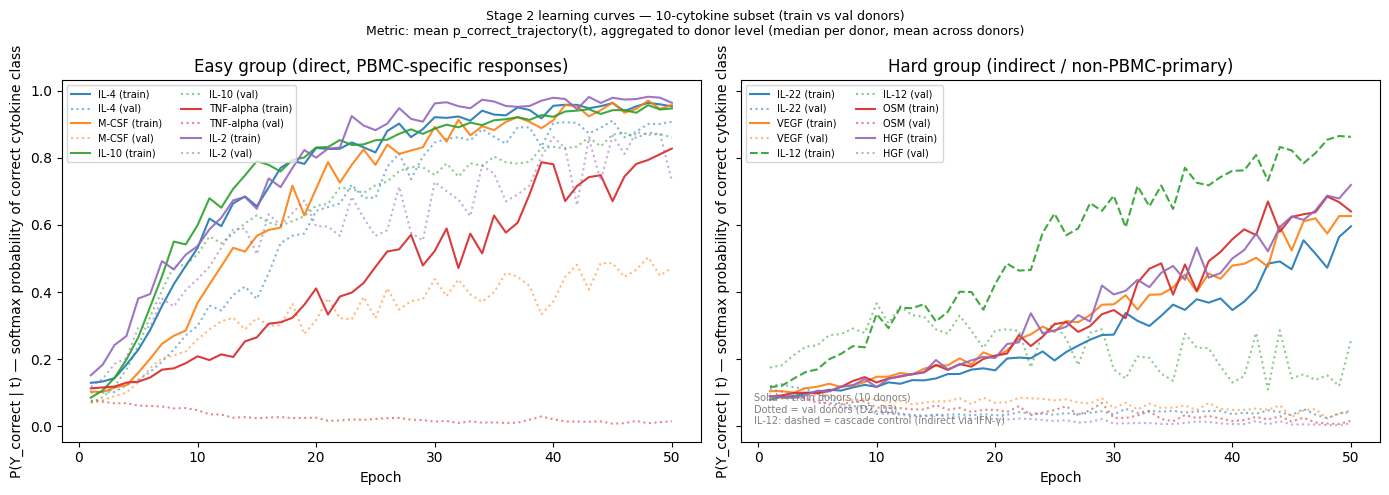

In [13]:
# Plot learning curves — train (solid) and val (dotted) in the same color per cytokine.
# A persistent train > val gap indicates the model is exploiting donor-specific expression.
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
epochs = dynamics_stage2["logged_epochs"]
colors = plt.cm.tab10.colors

for ax, group, group_label in zip(
    axes,
    [EASY_CYTOKINES, HARD_CYTOKINES],
    ["Easy group (direct, PBMC-specific responses)", "Hard group (indirect / non-PBMC-primary)"],
):
    for ci, cyt in enumerate(group):
        color = colors[ci % len(colors)]
        ls_mod = "--" if cyt == "IL-12" else "-"
        if cyt in donor_traj:
            train_mean = np.mean(list(donor_traj[cyt].values()), axis=0)
            ax.plot(epochs, train_mean, color=color, linestyle=ls_mod,
                    alpha=0.9, label=f"{cyt} (train)")
        if cyt in val_donor_traj:
            val_mean = np.mean(list(val_donor_traj[cyt].values()), axis=0)
            ax.plot(epochs, val_mean, color=color, linestyle=":",
                    alpha=0.55, label=f"{cyt} (val)")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("P(Y_correct | t) — softmax probability of correct cytokine class")
    ax.set_title(group_label)
    ax.legend(fontsize=7, ncol=2)

axes[1].annotate(
    "Solid = train donors (10 donors)\nDotted = val donors (D2, D3)\nIL-12: dashed = cascade control (indirect via IFN-γ)",
    xy=(0.02, 0.05), xycoords="axes fraction", fontsize=7, color="gray",
)

plt.suptitle(
    "Stage 2 learning curves — 10-cytokine subset (train vs val donors)\n"
    "Metric: mean p_correct_trajectory(t), aggregated to donor level "
    "(median per donor, mean across donors)",
    fontsize=9,
)
plt.tight_layout()
plt.savefig("learning_curves_subset_trainval.png", dpi=150)
plt.show()

In [14]:
# Attention entropy summary — train and val
entropy_result     = compute_cytokine_entropy_summary(dynamics_stage2["records"])
val_entropy_result = compute_cytokine_entropy_summary(dynamics_stage2["val_records"])
entropy_summary     = entropy_result["summary"]
val_entropy_summary = val_entropy_result["summary"]

# Sort by train mean entropy (low=focused, high=pleiotropic)
entropy_sorted = sorted(entropy_summary.items(), key=lambda x: x[1]["mean_entropy"])

print("Cytokine attention entropy summary")
print(f"Metric: {entropy_result['metric_description']}")
print()
print(f"{'Cytokine':<20}  {'Train H':>10}  {'Val H':>8}  Group")
print("-" * 50)
for cyt, stats in entropy_sorted:
    group = "EASY" if cyt in EASY_CYTOKINES else ("HARD" if cyt in HARD_CYTOKINES else "PBS")
    val_h = val_entropy_summary.get(cyt, {}).get("mean_entropy", float("nan"))
    print(f"  {cyt:<20}  {stats['mean_entropy']:>10.3f}  {val_h:>8.3f}  {group}")

Cytokine attention entropy summary
Metric: mean across epochs and pseudo-tubes of H(attention_weights) = -sum_i a_i * log(a_i), aggregated to donor level (median across pseudo-tubes per donor, then mean across donors)

Cytokine                 Train H     Val H  Group
--------------------------------------------------
  TNF-alpha                  2.847     3.461  EASY
  HGF                        2.986     3.392  HARD
  PBS                        3.001     3.627  PBS
  OSM                        3.025     3.543  HARD
  IL-10                      3.048     3.171  EASY
  IL-4                       3.183     3.293  EASY
  M-CSF                      3.204     3.527  EASY
  IL-22                      3.244     3.549  HARD
  VEGF                       3.246     3.473  HARD
  IL-2                       3.378     3.576  EASY
  IL-12                      3.598     3.543  HARD


In [15]:
# Confusion entropy summary — train and val
confusion_result = compute_confusion_entropy_summary(
    dynamics_stage2["confusion_entropy_trajectory"], exclude=["PBS"]
)
val_confusion_result = compute_confusion_entropy_summary(
    dynamics_stage2["val_confusion_entropy_trajectory"], exclude=["PBS"]
)
val_conf_map = {cyt: auc for cyt, auc in val_confusion_result["ranking"]}

print("Cytokine confusion entropy ranking")
print(f"Metric: {confusion_result['metric_description']}")
print()
print(f"{'Cytokine':<20}  {'Train AUC(H_c)':>14}  {'Val AUC(H_c)':>12}  Group")
print("-" * 62)
for cyt, auc in confusion_result["ranking"]:
    group = "EASY" if cyt in EASY_CYTOKINES else ("HARD" if cyt in HARD_CYTOKINES else "PBS")
    val_auc = val_conf_map.get(cyt, float("nan"))
    print(f"  {cyt:<20}  {auc:>14.3f}  {val_auc:>12.3f}  {group}")

Cytokine confusion entropy ranking
Metric: AUC of H_confusion(C,t) = -sum_{k!=C} q_k(t) * log(q_k(t)), where q_k(t) is the renormalized off-diagonal mean softmax score across all pseudo-tubes of cytokine C at epoch t. Low = confusion concentrated on similar cytokines (similarity confound). High = confusion spread randomly (genuine difficulty).

Cytokine              Train AUC(H_c)  Val AUC(H_c)  Group
--------------------------------------------------------------
  M-CSF                        105.413        73.868  EASY
  IL-4                         105.114       103.454  EASY
  IL-10                        103.960        85.256  EASY
  HGF                          102.674        81.719  HARD
  OSM                          101.642        90.038  HARD
  VEGF                         101.103        92.592  HARD
  IL-12                        100.972        68.667  HARD
  IL-22                         99.689        88.002  HARD
  TNF-alpha                     97.102        83.737  EASY
 

## 6. Validation

In [16]:
# --- Donor-level generalization check (see CLAUDE.md Section 16) ---
# Val donors D2 and D3 were selected as the most biologically distinct donors:
#   D3: highest baseline ISG expression (worst-case IFN generalization test)
#   D2: aberrant CD14 Mono baseline resembling IL-32-β-stimulated state
# Neither donor contributed any gradient updates to the model.

train_ranking_list = rank_cytokines_by_learnability(donor_traj,     exclude=["PBS"])["ranking"]
val_ranking_list   = rank_cytokines_by_learnability(val_donor_traj, exclude=["PBS"])["ranking"]

train_order = [c for c, _ in train_ranking_list]
val_order   = [c for c, _ in val_ranking_list]
val_rank_by_cyt = {c: i for i, c in enumerate(val_order)}
val_ranks_aligned = [val_rank_by_cyt[c] for c in train_order]

rho, pval = spearmanr(range(len(train_order)), val_ranks_aligned)

print("Donor-level generalization check — Stage 2")
print(f"  Train donors: {sorted({e['donor'] for e in train_manifest})}")
print(f"  Val donors:   {VAL_DONORS}  (never used in optimizer steps)")
print()
print(f"  Train/val rank correlation: Spearman rho = {rho:.3f}  (p={pval:.3f})")
print(f"  Stable (rho > 0.7): {rho > 0.7}")
print()
print("  Per-cytokine AUC (Train vs Val):")
print(f"  {'Cytokine':<20}  {'Train AUC':>10}  {'Val AUC':>9}  {'Ratio V/T':>10}")
print("  " + "-" * 56)
val_auc_map2 = {c: a for c, a in val_ranking_list}
for cyt, train_auc in train_ranking_list:
    val_auc = val_auc_map2.get(cyt, float("nan"))
    ratio = val_auc / train_auc if train_auc > 0 else float("nan")
    flag = "  ← possible overfit" if ratio < 0.6 else ""
    print(f"  {cyt:<20}  {train_auc:>10.3f}  {val_auc:>9.3f}  {ratio:>10.2f}{flag}")
print()
print("  Interpretation:")
print("    V/T ratio ≈ 1.0 → cytokine program generalizes to held-out donors.")
print("    V/T ratio << 1  → model may be exploiting donor-specific expression patterns.")

Donor-level generalization check — Stage 2
  Train donors: ['Donor1', 'Donor10', 'Donor11', 'Donor12', 'Donor4', 'Donor5', 'Donor6', 'Donor7', 'Donor8', 'Donor9']
  Val donors:   ['Donor2', 'Donor3']  (never used in optimizer steps)

  Train/val rank correlation: Spearman rho = 0.745  (p=0.013)
  Stable (rho > 0.7): True

  Per-cytokine AUC (Train vs Val):
  Cytokine               Train AUC    Val AUC   Ratio V/T
  --------------------------------------------------------
  IL-2                      38.469     29.802        0.77
  IL-10                     37.433     32.196        0.86
  IL-4                      36.926     30.875        0.84
  M-CSF                     33.726     16.690        0.49  ← possible overfit
  IL-12                     25.993     11.519        0.44  ← possible overfit
  TNF-alpha                 22.233      1.309        0.06  ← possible overfit
  HGF                       16.304      1.278        0.08  ← possible overfit
  OSM                       16.183    

In [17]:
# Seed stability — run with all three seeds from config
# NOTE: Pre-register your directional predictions BEFORE looking at these results.

all_dynamics = [dynamics_stage2]  # Add dynamics from other seeds here

# Example: to run with additional seeds, re-run train_mil with seed=123 and seed=7
# and append to all_dynamics.

if len(all_dynamics) > 1:
    stability = check_seed_stability(all_dynamics, exclude=["PBS"])
    print(f"Mean Spearman rho across seeds: {stability['mean_rho']:.3f}")
    print(f"Stable ordering: {stability['stable']}")
else:
    print("Run with multiple seeds to assess stability. See config random_seeds.")

Run with multiple seeds to assess stability. See config random_seeds.


In [18]:
# Known functional groupings
# IL-4, IL-10, IL-2 all signal through PBMC-expressed receptors — expected similar learnability.
# VEGF, HGF, IL-22 all target non-PBMC cell types — expected similarly low learnability.
# IL-12 is deliberately excluded from the hard-group clustering check: it is a cascade
# control and its biological interpretation requires the learnability ranking to be read first.
known_groups = {
    "pbmc_direct_activators": ["IL-4", "IL-10", "IL-2"],
    "non_pbmc_targets": ["VEGF", "HGF", "IL-22"],
}

grouping_result = check_functional_groupings(donor_traj, known_groups)
for group, result in grouping_result.items():
    print(f"\n{group}:")
    for k, v in result.items():
        print(f"  {k}: {v}")


pbmc_direct_activators:
  members_found: ['IL-4', 'IL-10', 'IL-2']
  within_auc_std: 0.6419290749758162
  between_auc_std: 6.4218342659505625
  passes: True

non_pbmc_targets:
  members_found: ['VEGF', 'HGF', 'IL-22']
  within_auc_std: 1.4652440671094924
  between_auc_std: 8.042132493905742
  passes: True


In [20]:
# Stage 2 vs Stage 3 ranking correlation — train and val
donor_traj_s3     = aggregate_to_donor_level(dynamics_stage3["records"])
val_donor_traj_s3 = aggregate_to_donor_level(dynamics_stage3["val_records"])

ranking_s3     = rank_cytokines_by_learnability(donor_traj_s3,     exclude=["PBS"])
val_ranking_s3 = rank_cytokines_by_learnability(val_donor_traj_s3, exclude=["PBS"])

stability_s2_s3 = check_seed_stability(
    [dynamics_stage2, dynamics_stage3], exclude=["PBS"]
)
print("Stage 2 vs Stage 3 ranking correlation")
print(
    "Metric: Spearman rho between cytokine learnability rankings "
    "(AUC of donor-level p_correct_trajectory, median per donor, mean across donors)"
)
print(f"  Train: Spearman rho = {stability_s2_s3['mean_rho']:.3f}")
print(f"  Stable across stages (rho > 0.7): {stability_s2_s3['stable']}")

# Val correlation across stages
val_s2_order = [c for c, _ in val_learnability_result["ranking"]]
val_s3_order = [c for c, _ in val_ranking_s3["ranking"]]
if set(val_s2_order) == set(val_s3_order):
    val_s3_aligned = [val_s3_order.index(c) for c in val_s2_order]
    rho_val, _ = spearmanr(range(len(val_s2_order)), val_s3_aligned)
    print(f"  Val:   Spearman rho = {rho_val:.3f}")

Stage 2 vs Stage 3 ranking correlation
Metric: Spearman rho between cytokine learnability rankings (AUC of donor-level p_correct_trajectory, median per donor, mean across donors)
  Train: Spearman rho = 0.879
  Stable across stages (rho > 0.7): True
  Val:   Spearman rho = 0.964
